In [3]:
import math, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

In [4]:
def prepare_data (location: str) -> pd.DataFrame:
    """Return pandas dataframe with proper labeled columns and adjusted
    values.

    Args:
        location (str): The location directory in string form.

    Returns:
        pd.DataFrame: data file -> pandas dataframe
    """
    cols = ['chr_i', 'pos_i', 'chr_j', 'pos_j', 'contacts']
    df = pd.read_csv(location, names=cols, sep=r'\s+')
    df['pos_i'] = df['pos_i'] // 1000000
    df['pos_j'] = df['pos_j'] // 1000000
    return df

In [5]:
def find_chr_length (data: pd.DataFrame) -> dict[str: tuple]:
    """Return a dictionary containing each unique chromosome mapped to their lengths
    as a tuple (min_length, max_length).
    
    Args:
        data (pd.DataFrame): DataFrame with ['chr_i', 'pos_i', 'chr_j', 'pos_j', 'contacts']

    Returns:
        dict: chromosome -> length (min, max)
    """
    chr_bounds = {}
    chromosomes = sorted(set(df['chr_i']).union(df['chr_j']), key=lambda x: int(x[3:]) if x[3:].isdigit() else 100)
    for chr_ in chromosomes:
            max_i = data.loc[data['chr_i'] == chr_, 'pos_i'].max()
            max_j = data.loc[data['chr_j'] == chr_, 'pos_j'].max()
            min_i = data.loc[data['chr_i'] == chr_, 'pos_i'].min()
            min_j = data.loc[data['chr_j'] == chr_, 'pos_j'].min()
            chr_bounds[chr_] = (min(min_i, min_j), max(max_i, max_j))
    return chr_bounds

In [6]:
def build_chr_block_matrix(data: pd.DataFrame) -> pd.DataFrame:
    """Return a DataFrame where rows and columns are chromosomes and
    each cell contains a symmetric contact matrix (DataFrame) between those chromosomes.

    Args:
        data (pd.DataFrame): DataFrame with ['chr_i', 'pos_i', 'chr_j', 'pos_j', 'contacts']

    Returns:
        pd.DataFrame: block DataFrame of contact matrices
    """
    # compute length of chromosome
    chr_bounds = find_chr_length(data)
    chromosomes = sorted(set(df['chr_i']).union(df['chr_j']), key=lambda x: int(x[3:]) if x[3:].isdigit() else 100)

    # initialize the block matrix as pandas dataframe
    chr_block_df = pd.DataFrame(index=chromosomes, columns=chromosomes, dtype=object)

    # fill each block/cell with sub contact matrices
    for chr_i in chromosomes:
        for chr_j in chromosomes:
            # set lengths for chromosome contact matrix
            min_i, max_i = chr_bounds[chr_i]
            min_j, max_j = chr_bounds[chr_j]
            row_bins = list(range(min_i, max_i + 1))
            col_bins = list(range(min_j, max_j + 1))

            # initialize zero matrix
            mat = pd.DataFrame(0, index=row_bins, columns=col_bins)

            # find subset of actual contact data for this chr pair
            subdf = data[(data['chr_i'] == chr_i) & (data['chr_j'] == chr_j)]

            # _ is just to run this loop and row represents the rows of data where contact occurs
            for _, row in subdf.iterrows():
                i, j = row['pos_i'], row['pos_j']
                mat.at[i, j] = row['contacts']
                # add symmetric entry if same chromosome
                if chr_i == chr_j:
                    mat.at[j, i] = row['contacts']
                    
            # set the contact matrix into the block matrix
            chr_block_df.at[chr_i, chr_j] = mat

    return chr_block_df

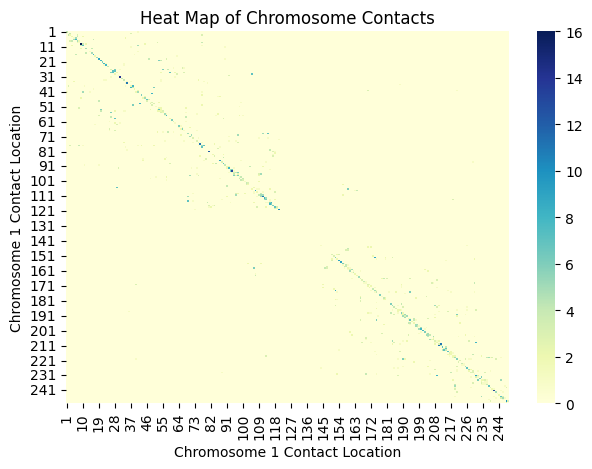

In [7]:
df = prepare_data('/Users/salah/Documents/hic-cell-classification/data/HAP1/ml1_AAGCCGGT-ATACATGT.txt')
matrix = build_chr_block_matrix(df)

sns.heatmap(matrix.at['chr1', 'chr1'], cmap='YlGnBu')
plt.title("Heat Map of Chromosome Contacts")
plt.xlabel("Chromosome 1 Contact Location")
plt.ylabel("Chromosome 1 Contact Location")
plt.tight_layout()
plt.show()

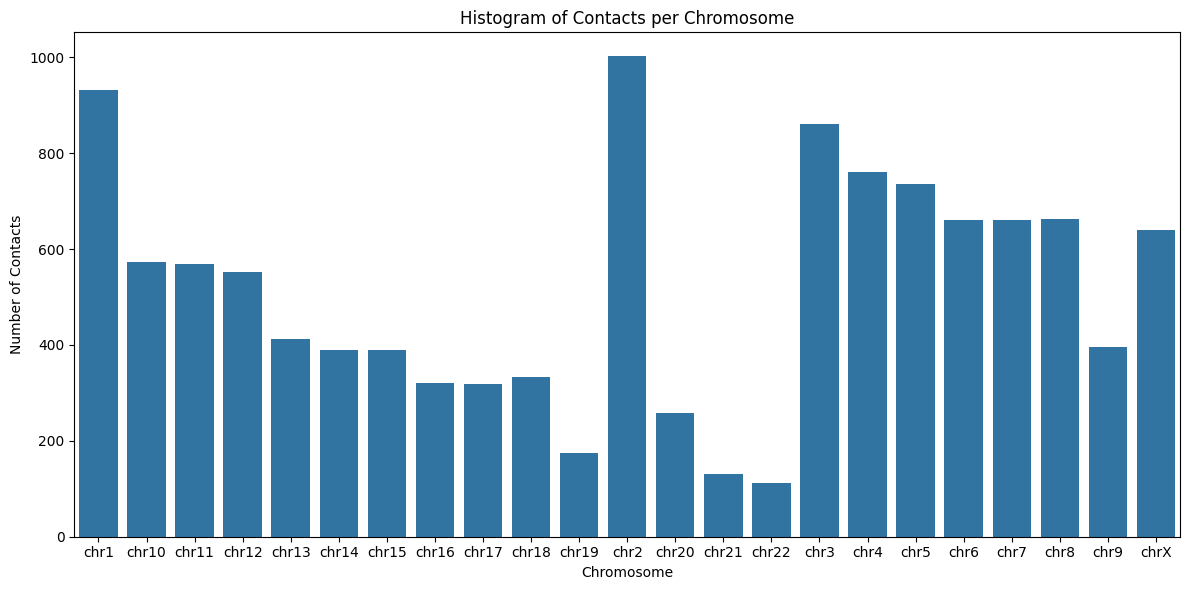

In [8]:
def sum_contacts(df: pd.DataFrame) -> pd.DataFrame:
    """
    Count total number of contacts per chromosome from both chr_i and chr_j.
    
    Args:
        df (pd.DataFrame): DataFrame with columns ['chr_i', 'chr_j']

    Returns:
        pd.Dataframe: chromosome -> number of contacts
    """
    counts_i = df['chr_i'].value_counts()
    counts_j = df['chr_j'].value_counts()
    
    total_counts = counts_i.add(counts_j, fill_value=0).astype(int)
    total_df = total_counts.reset_index()
    total_df.columns = ['chromosome', 'total_contacts']

    return total_df.sort_values(by='chromosome')

contact_count = sum_contacts(df)
plt.figure(figsize=(12, 6))
sns.barplot(x='chromosome', y='total_contacts', data=contact_count)
plt.title("Histogram of Contacts per Chromosome")
plt.xlabel("Chromosome")
plt.ylabel("Number of Contacts")
plt.tight_layout()
plt.show()

In [9]:
def cell_summary_stats(data: pd.DataFrame) -> dict:
    """Return a dictionary containing summary statistics of the cell.

    Args:
        df (pd.DataFrame): contact data with ['chr_i', 'pos_i', 'chr_j', 'pos_j', 'contacts']

    Returns:
        dict: feature_name -> value
    """
    total_contacts = data['contacts'].sum()
    mean_contact = data['contacts'].mean()
    var_contact = data['contacts'].var()

    features = {
        'total_cell_contact': float(total_contacts),
        'mean_cell_contact': float(mean_contact),
        'var_cell_contact': float(var_contact),
    }
    return features

In [10]:
def per_chr_summary_stats(df: pd.DataFrame, matrix: pd.DataFrame) -> dict:
    """
    Return a dictionary mapping each chromosome (chr1, chr2, ...) to a
    sub-dictionary of total, mean, and variance of contact values 
    involving that chromosome (either chr_i or chr_j).

    Args:
        df (pd.DataFrame): DataFrame with columns ['chr_i', 'pos_i', 'chr_j', 'pos_j', 'contacts']
        matrix (pd.DataFrame): block matrix with diagonal contact matrices

    Returns:
        dict: { 'chr1': { 'total': ..., 'mean': ..., 'var': ... }, ... }
    """
    chromosomes = sorted(set(df['chr_i']).union(df['chr_j']), key=lambda x: int(x[3:]) if x[3:].isdigit() else 100)
    result = {}

    for chr_ in chromosomes:
        chr_df = df[(df['chr_i'] == chr_) | (df['chr_j'] == chr_)]
        contacts = chr_df['contacts'].values

        if len(contacts) > 0:
            result[chr_] = {
                'total': float(contacts.sum()),
                'mean': float(contacts.mean()),
                'var': float(contacts.var())
            }
        else:
            result[chr_] = {'total': 0.0, 'mean': 0.0, 'var': 0.0}
            
    chr_diagonal = {}
    
    for chr in matrix.index:
        chr_diagonal[chr] = matrix.at[chr, chr]
        
    
    for chr in chr_diagonal:
        diagonal = np.diag(chr_diagonal[chr])
        result[chr].update({'total_diagonal': float(diagonal.sum()),
                       'mean_diagonal': float(diagonal.mean()),
                       'var_diagonal': float(diagonal.var())})
    return result

In [11]:
hap1stats = per_chromosome_contact_stats(df, matrix)
print(hap1stats)

NameError: name 'per_chromosome_contact_stats' is not defined

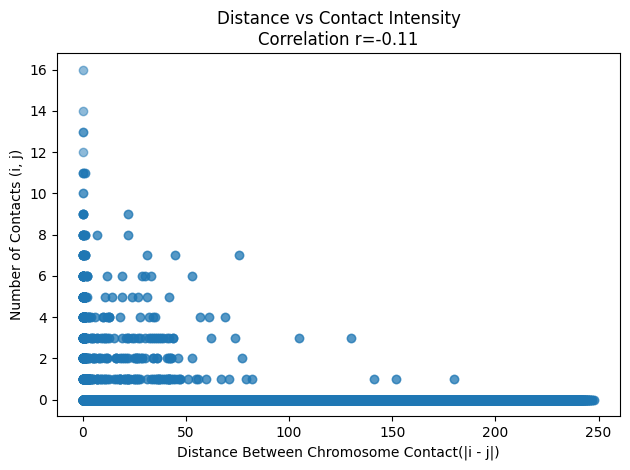

In [12]:
def calculate_dist_contact(matrix: pd.DataFrame) -> dict:
    """
    Compute distance-from-diagonal vs contact intensity for a symmetric matrix.

    Args:
        matrix (pd.DataFrame): contact matrix (e.g., chr3 vs chr3)

    Returns:
        dict: {
            'distances': list of |i - j| (distance between contact points),
            'contacts': list of contacts,
            'correlation': Pearson correlation (distance vs contact)
        }
    """
    distances = []
    contacts = []

    idx_to_pos = list(matrix.index)
    col_to_pos = list(matrix.columns)

    for i, row_pos in enumerate(idx_to_pos):
        for j, col_pos in enumerate(col_to_pos):
            contact = matrix.iat[i, j] # The contact on the i, j position
            dist = abs(i - j) # distance from position i to j
            distances.append(dist)
            contacts.append(contact)

    # Correlation analysis
    corr, _ = pearsonr(distances, contacts) # calculate linear correlation

    return {'distances': distances, 'contacts': contacts, 
            'correlation': corr}

contact_matrix = matrix.at['chr1', 'chr1'] 
dist_contact = calculate_dist_contact(contact_matrix)

plt.scatter(dist_contact['distances'], dist_contact['contacts'], alpha=0.5)
plt.title(f"Distance vs Contact Intensity\nCorrelation r={dist_contact['correlation']:.2f}")
plt.xlabel("Distance Between Chromosome Contact(|i - j|)")
plt.ylabel("Number of Contacts (i, j)")
plt.tight_layout()
plt.show()

In [13]:
def read_all_in_cell_type(folder_path: str, file_suffix: str=".txt") -> pd.DataFrame:
    """
    Loop through all cell files in a folder and extract features.

    Args:
        folder_path (str): Path to directory with cell contact files.
        file_suffix (str): File extension to filter on.

    Returns:
        pd.DataFrame: One row per cell, columns are features.
    """
    cells = []
    
    for fname in os.listdir(folder_path):
        if fname.endswith(file_suffix):
            cell_id = os.path.splitext(fname)[0]
            cell_path = os.path.join(folder_path, fname)
            
        try:
            features = {'cell_id': cell_id}
            df = prepare_data(location=cell_path)
            matrix = build_chr_block_matrix(df)
            features.update(cell_summary_stats(df))
            features.update(per_chr_summary_stats(df , matrix))
            cells.append(features)
        except Exception as error:
            print(f"Exception raised for {fname} due to error: {error}")
    return pd.DataFrame(data=cells).set_index('cell_id')

gm_12878 = read_all_in_cell_type(folder_path='/Users/salah/Documents/hic-cell-classification/data/GM12878')
hap_1 = read_all_in_cell_type(folder_path='/Users/salah/Documents/hic-cell-classification/data/HAP1')
hela = read_all_in_cell_type(folder_path='/Users/salah/Documents/hic-cell-classification/data/Hela')
k_562 = read_all_in_cell_type(folder_path='/Users/salah/Documents/hic-cell-classification/data/K562')

In [110]:
gm_12878.head()

,block_matrix,total_cell_contact,mean_cell_contact,var_cell_contact,chr1,chr2,chr3,chr4,chr5,chr6,...,chr14,chr15,chr16,chr17,chr18,chr19,chr20,chr21,chr22,chrX
cell_id,,,,,,,,,,,,,,,,,,,,,
ml3_CTGAGGCA-TTCTCGAG,...,2770.0,1.299859,0.395019,"{'total': 237.0, 'mean': 1.2216494845360826, '...","{'total': 250.0, 'mean': 1.366120218579235, 'v...","{'total': 194.0, 'mean': 1.3287671232876712, '...","{'total': 160.0, 'mean': 1.2598425196850394, '...","{'total': 190.0, 'mean': 1.3571428571428572, '...","{'total': 161.0, 'mean': 1.2677165354330708, '...",...,"{'total': 84.0, 'mean': 1.3125, 'var': 0.37109...","{'total': 78.0, 'mean': 1.3220338983050848, 'v...","{'total': 61.0, 'mean': 1.3555555555555556, 'v...","{'total': 66.0, 'mean': 1.346938775510204, 'va...","{'total': 50.0, 'mean': 1.1904761904761905, 'v...","{'total': 39.0, 'mean': 1.2580645161290323, 'v...","{'total': 69.0, 'mean': 1.2105263157894737, 'v...","{'total': 28.0, 'mean': 1.1666666666666667, 'v...","{'total': 51.0, 'mean': 1.5454545454545454, 'v...","{'total': 128.0, 'mean': 1.2075471698113207, '..."
ml3_CCTCCTCA-ATATCAGA,...,11790.0,1.960426,2.126157,"{'total': 921.0, 'mean': 1.891170431211499, 'v...","{'total': 1048.0, 'mean': 1.8548672566371682, ...","{'total': 902.0, 'mean': 1.9955752212389382, '...","{'total': 830.0, 'mean': 1.9437939110070257, '...","{'total': 763.0, 'mean': 2.0078947368421054, '...","{'total': 709.0, 'mean': 1.9804469273743017, '...",...,"{'total': 296.0, 'mean': 2.0136054421768708, '...","{'total': 310.0, 'mean': 2.066666666666667, 'v...","{'total': 281.0, 'mean': 1.965034965034965, 'v...","{'total': 299.0, 'mean': 2.4916666666666667, '...","{'total': 324.0, 'mean': 2.050632911392405, 'v...","{'total': 220.0, 'mean': 2.3404255319148937, '...","{'total': 307.0, 'mean': 2.3435114503816794, '...","{'total': 104.0, 'mean': 1.8571428571428572, '...","{'total': 134.0, 'mean': 2.3508771929824563, '...","{'total': 532.0, 'mean': 1.6419753086419753, '..."
ml3_CACGGATC-TGAGGCAA,...,4144.0,1.335482,0.470588,"{'total': 355.0, 'mean': 1.3601532567049808, '...","{'total': 385.0, 'mean': 1.3652482269503545, '...","{'total': 314.0, 'mean': 1.3305084745762712, '...","{'total': 274.0, 'mean': 1.3300970873786409, '...","{'total': 265.0, 'mean': 1.3054187192118227, '...","{'total': 256.0, 'mean': 1.3689839572192513, '...",...,"{'total': 133.0, 'mean': 1.3711340206185567, '...","{'total': 99.0, 'mean': 1.3026315789473684, 'v...","{'total': 104.0, 'mean': 1.3164556962025316, '...","{'total': 107.0, 'mean': 1.4266666666666667, '...","{'total': 117.0, 'mean': 1.3448275862068966, '...","{'total': 60.0, 'mean': 1.3636363636363635, 'v...","{'total': 88.0, 'mean': 1.4426229508196722, 'v...","{'total': 47.0, 'mean': 1.3823529411764706, 'v...","{'total': 39.0, 'mean': 1.4444444444444444, 'v...","{'total': 217.0, 'mean': 1.1988950276243093, '..."
ml3_AAGCGACC-ACCTCTTG,...,5834.0,1.593554,1.104702,"{'total': 288.0, 'mean': 1.3714285714285714, '...","{'total': 482.0, 'mean': 1.4968944099378882, '...","{'total': 308.0, 'mean': 1.4597156398104265, '...","{'total': 326.0, 'mean': 1.4684684684684686, '...","{'total': 268.0, 'mean': 1.46448087431694, 'va...","{'total': 704.0, 'mean': 1.9287671232876713, '...",...,"{'total': 254.0, 'mean': 1.7887323943661972, '...","{'total': 178.0, 'mean': 1.5478260869565217, '...","{'total': 121.0, 'mean': 1.6805555555555556, '...","{'total': 113.0, 'mean': 1.4487179487179487, '...","{'total': 64.0, 'mean': 1.3061224489795917, 'v...","{'total': 171.0, 'mean': 1.9883720930232558, '...","{'total': 80.0, 'mean': 1.5384615384615385, 'v...","{'total': 34.0, 'mean': 1.3076923076923077, 'v...","{'total': 89.0, 'mean': 1.78, 'var': 1.3316, '...","{'total': 386.0, 'mean': 1.5196850393700787, '..."
ml3_TCGGATCG-CGCTTAAT,...,4641.0,1.493724,0.765817,"{'total': 370.0, 'mean': 1.4624505928853755, '...","{'total': 385.0, 'mean': 1.405109489051095, 'v...","{'total': 348.0, 'mean': 1.5330396475770924, '...","{'total': 258.0, 'mean': 1.3796791443850267, '...","{

In [15]:
def get_chr_summary_data(df: pd.DataFrame, cell_type: str, stat: str) -> pd.DataFrame:
    """
    Converts per-cell chromosome columns (containing dicts) into long format
    with one row per cell and chromosome and stat.

    Args:
        df (pd.DataFrame): per-cell DataFrame (each chr column is a dict of stats)
        stat (str): the stat to extract ('total', 'mean', 'var')

    Returns:
        pd.DataFrame: ['cell_id', 'chromosome', 'value']
    """
    records = []

    for cell_id, row in df.iterrows():
        for col in df.columns:
            if col.startswith('chr'):
                chr_stats = row[col]
                if isinstance(chr_stats, dict) and stat in chr_stats:
                    records.append({
                        'cell_id': cell_id,
                        'cell_type': cell_type,
                        'chromosome': col,
                        stat: chr_stats[stat]
                    })
            elif col == stat:
                chr_stat = row[col]
                records.append({
                        'cell_id': cell_id,
                        'cell_type': cell_type,
                        stat: chr_stat
                    })
    return pd.DataFrame(records)

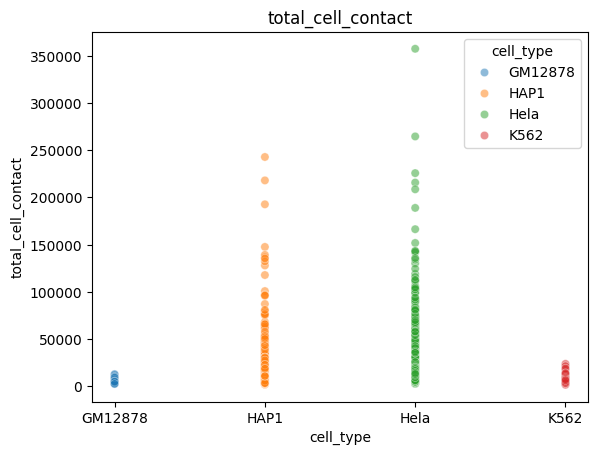

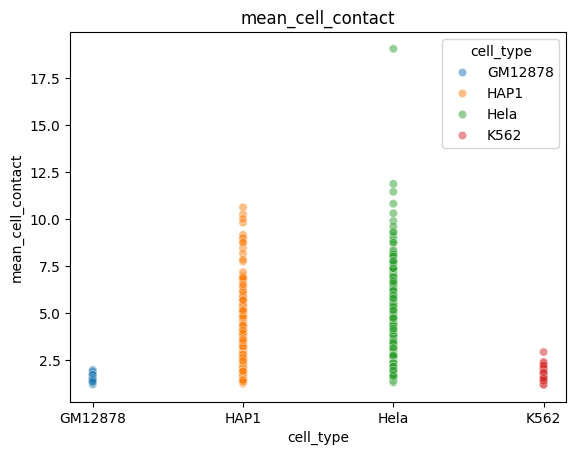

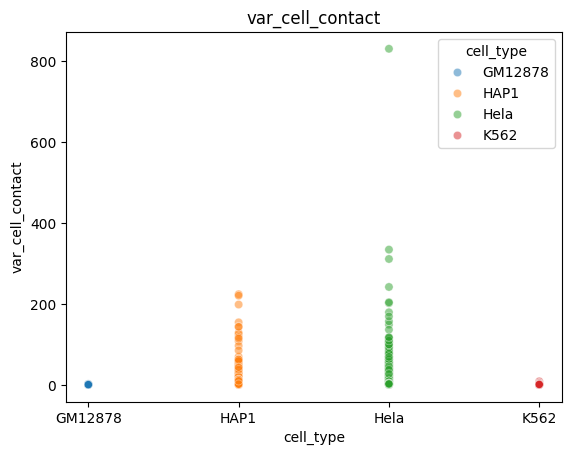

In [18]:
for col in gm_12878.columns[0:3]:
    chr_total_gm_12878 = get_chr_summary_data(gm_12878, 'GM12878', col)
    chr_total_hap_1 = get_chr_summary_data(hap_1, 'HAP1', col)
    chr_total_hela = get_chr_summary_data(hela, 'Hela', col)
    chr_total_k_562 = get_chr_summary_data(k_562, 'K562', col)
    combined_df = pd.concat([chr_total_gm_12878, chr_total_hap_1, chr_total_hela, chr_total_k_562], ignore_index=True)
    sns.scatterplot(combined_df, x='cell_type', y=col, hue='cell_type', alpha=0.5)
    plt.title(col)
    plt.show()

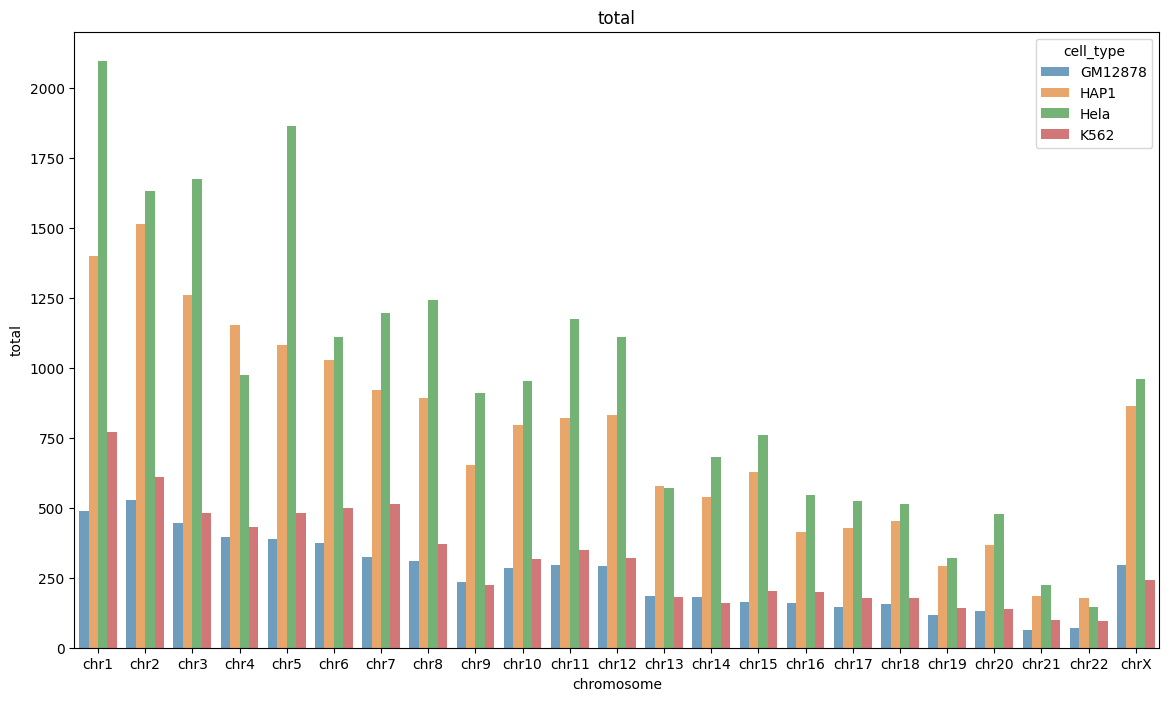

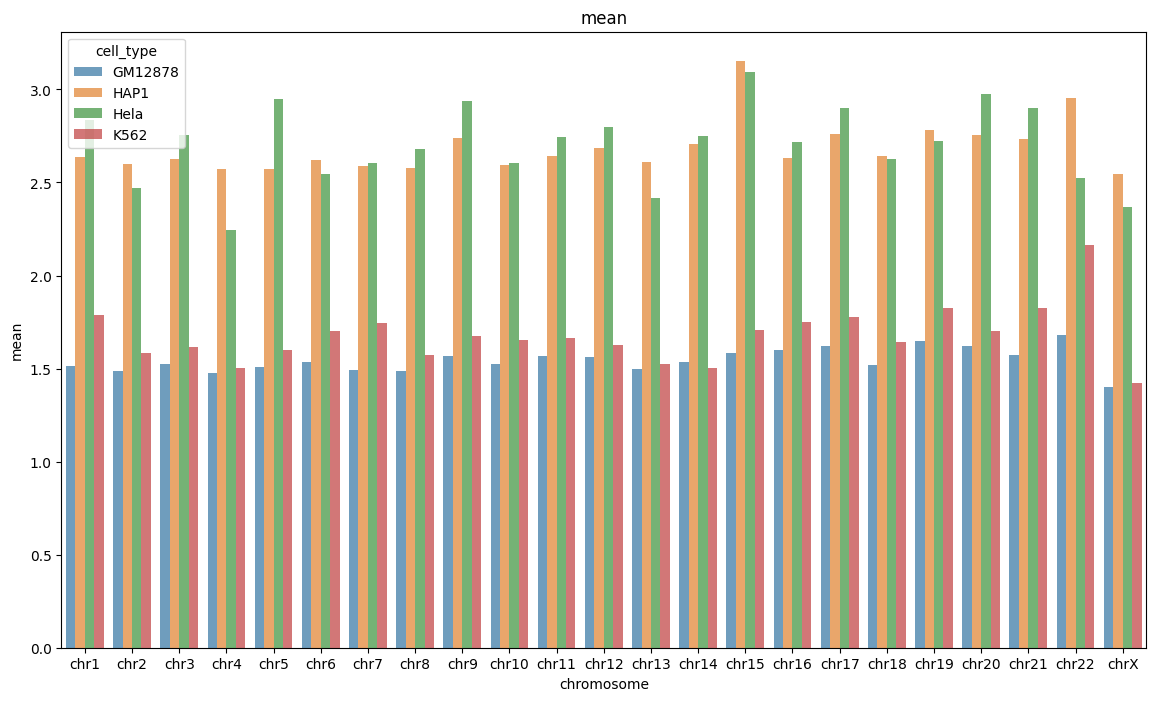

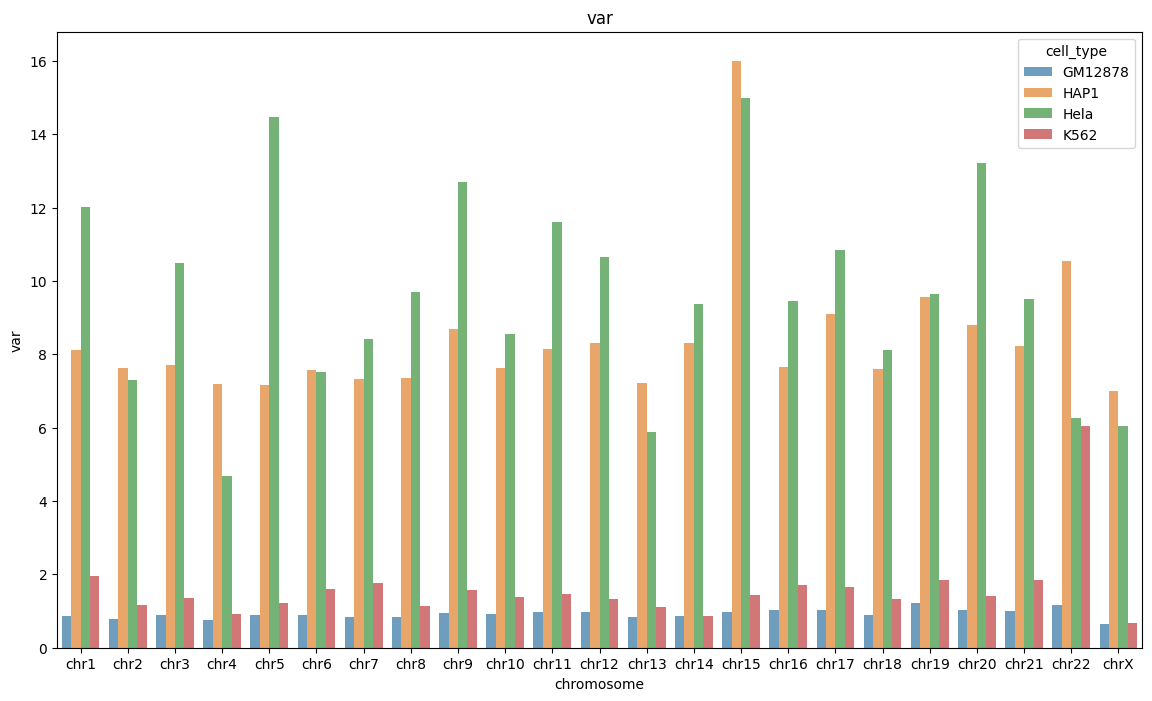

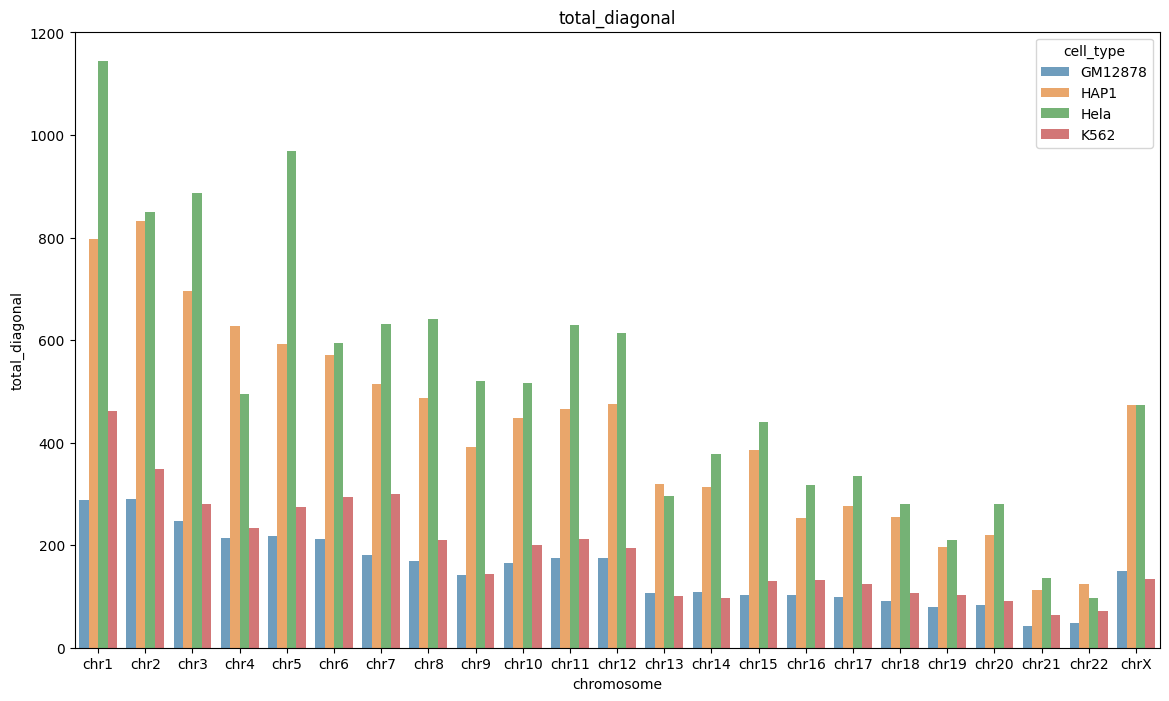

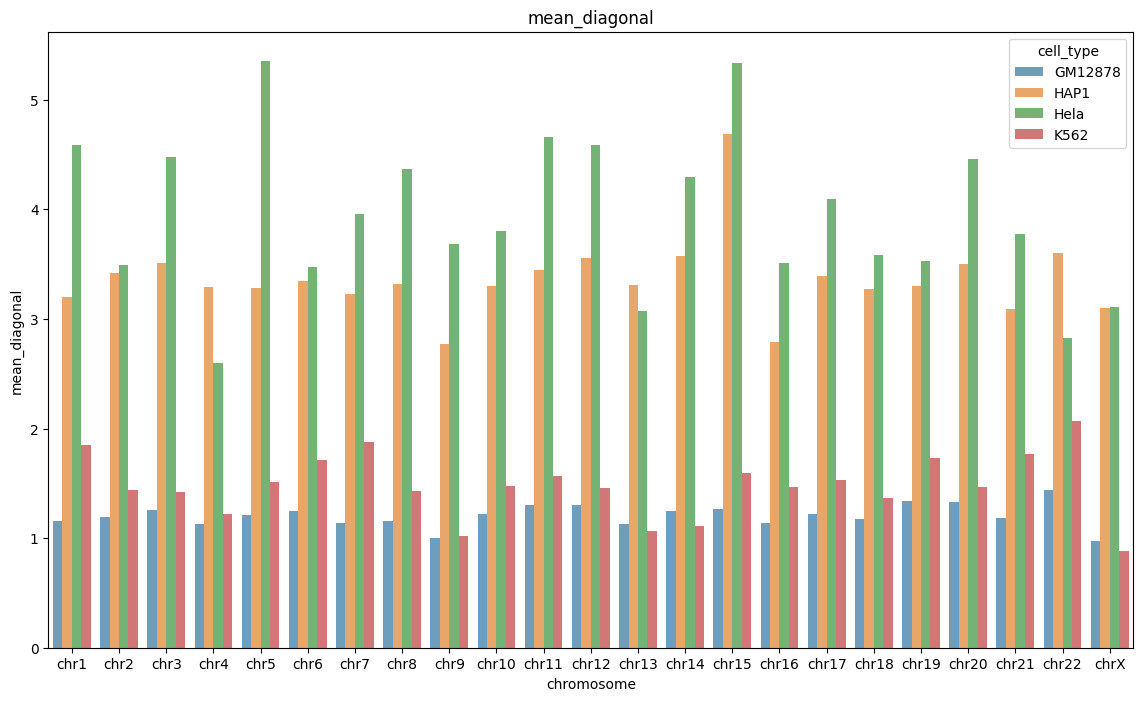

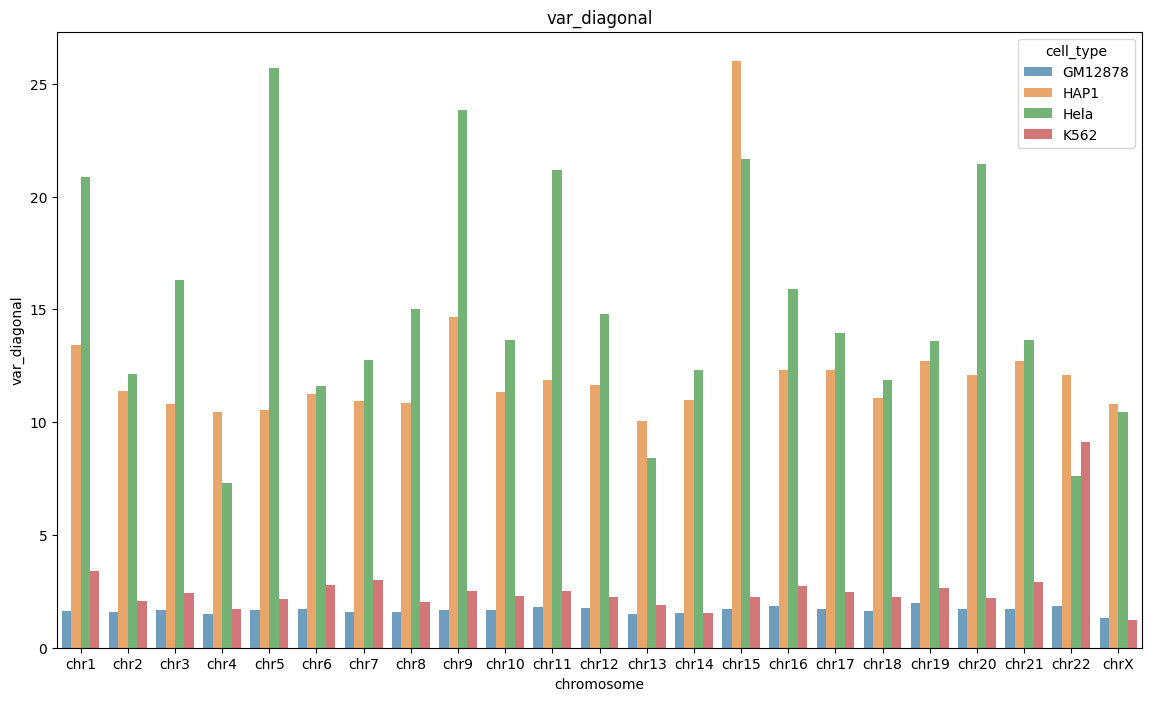

In [17]:
stats = ['total', 'mean', 'var', 'total_diagonal', 'mean_diagonal', 'var_diagonal']

for col in stats:
    chr_total_gm_12878 = get_chr_summary_data(gm_12878, 'GM12878', col)
    chr_total_hap_1 = get_chr_summary_data(hap_1, 'HAP1', col)
    chr_total_hela = get_chr_summary_data(hela, 'Hela', col)
    chr_total_k_562 = get_chr_summary_data(k_562, 'K562', col)
    combined_df = pd.concat([chr_total_gm_12878, chr_total_hap_1, chr_total_hela, chr_total_k_562], ignore_index=True)
    plt.figure(figsize=(14, 8))
    sns.barplot(combined_df, x='chromosome', y=col, hue='cell_type', alpha=0.7, errorbar=None)
    plt.title(col)
    plt.show()